In [1]:
## all imports
from IPython.display import HTML
import numpy as np
#import urllib2 (Python2)
import urllib.request
import bs4 #this is beautiful soup
import time
import operator
import socket
#import cPickle (Python2)
import pickle
import re # regular expressions

from pandas import Series
import pandas as pd
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

# Scraping data science skills

- What skills are in demand for data scientists?
- Should we have a lecture on Spark or only on MapReduce?

We want to scrape the information from job advertisements for data scientists from indeed.com
Let's scrape and find out!

### Get website and parse html
Using `BeautifulSoup` the html code of the Dutch version of indeed.com is parsed.

In [2]:
# Fixed url for job postings containing data scientist
url = 'https://www.indeed.nl/jobs?q=data+scientist&l='
# read the website
source = urllib.request.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source)

### Job count
Find the number of postings. Basically the search count is located on the 1st page of the website; use your browser's web developer tools to find the related tag and attributes. As this is a string we must cast it to an int taking into account possible thousands separators.<br><br>See also Remarks at the end of this notebook.

In [3]:
# August 2020 solution. Since 2015 Indeed.com altered the precise location of the total count of pages.
result_string = bs_tree.find('div', attrs = {"id": "searchCountPages"}).text
job_count_string = result_string.split(' ')[-2]
print ("Number of hits: ", job_count_string)
# statements below to handle thousands separator
job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], range(len(job_count_digits)))])
print (job_count)

Number of hits:  897
897


### Job links
The original CS109 2015 version assumes an exact amount of max 10 job postings per web page. At least on `indeed.nl` in August 2020 a variable number of job postings per page was encountered. So the number of pages calculation `num_pages = int(np.ceil(job_count/10))` is incorrect and cannot be used in the for loop. <br>
The solution is to find all job postings per page (irrelevant if this is less or more than 10) in a while loop as long as the job_count is > 0. The job_count is decremented with number of jobs found on that page.<br><br>
See also Remarks at the end of this notebook.

In [4]:
base_url = "https://www.indeed.nl"
job_links = []
i = 0
print (job_count)
while job_count > 0:
    job_postings = job_ids =[]
    # first page
    if i == 0:
        url = 'https://www.indeed.nl/jobs?q=data+scientist&l='
    else:
        url = 'https://www.indeed.nl/jobs?q=data+scientist&start=' + str(i * 10)
    html_page = urllib.request.urlopen(url).read()
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    # list with all divs of class "row result" in it
    job_postings = job_link_area.findAll("div", class_="jobsearch-SerpJobCard unifiedRow row result") 
    job_ids = [jp.get('data-jk') for jp in job_postings]
    # then for each job_link
    for id in job_ids:
        job_links.append(base_url + '/rc/clk?jk=' + id)
    time.sleep(1)
    job_count -= len(job_ids)
    print ("We found a lot of jobs: ", len(job_links), ". Remaining jobcount: ", job_count)
    i += 1

897
We found a lot of jobs:  15 . Remaining jobcount:  882
We found a lot of jobs:  30 . Remaining jobcount:  867
We found a lot of jobs:  45 . Remaining jobcount:  852
We found a lot of jobs:  60 . Remaining jobcount:  837
We found a lot of jobs:  75 . Remaining jobcount:  822
We found a lot of jobs:  90 . Remaining jobcount:  807
We found a lot of jobs:  105 . Remaining jobcount:  792
We found a lot of jobs:  121 . Remaining jobcount:  776
We found a lot of jobs:  136 . Remaining jobcount:  761
We found a lot of jobs:  151 . Remaining jobcount:  746
We found a lot of jobs:  166 . Remaining jobcount:  731
We found a lot of jobs:  181 . Remaining jobcount:  716
We found a lot of jobs:  196 . Remaining jobcount:  701
We found a lot of jobs:  211 . Remaining jobcount:  686
We found a lot of jobs:  226 . Remaining jobcount:  671
We found a lot of jobs:  241 . Remaining jobcount:  656
We found a lot of jobs:  256 . Remaining jobcount:  641
We found a lot of jobs:  271 . Remaining jobcount:

### Some precautions to enable us to restart our search
Write job_links to a file so it may be retrieved if needed.

In [5]:
# Save the scraped links
with open('data/scraped_links.pkl', 'wb') as f:
    pickle.dump(job_links, f)
    
# Read canned scraped links. 2nd arg should be `rb` read-binary
with open('data/scraped_links.pkl', 'rb') as f:
    job_links = pickle.load(f)

### Skill set
The desired skills to count in our job_link pages is stored in dictionary with value 0 as initialized count.

In [6]:
skill_set = {'mapreduce': 0, 'spark': 0, 'python': 0, 'r': 0, 'sql': 0, 'nosql': 0, 'sas': 0} 
# R is troublesome => in RE use raw string for \b which matches empty string before begin or after end of R

## write initialization into a file, so we can restart later
with open('data/scraped_links_restart.pkl', 'wb') as f:
    pickle.dump((skill_set, 0),f)
## read dictionary and index    
#with open('data/scraped_links_restart.pkl', 'rb') as f:
#    skill_set, index = pickle.load(f)

### Check progress
Code might be run to see the number of web_links yet to go. Code comment: CS109 2015

In [7]:
# This code below does the trick, but could be optimized for speed if necessary
# e.g. skills are typically listed at the end of the webpage
# might not need to split/join the whole webpage, as we already know
# which words we are looking for 
# and could stop after the first occurance of each word

with open('data/scraped_links_restart.pkl', 'rb') as f:
    skill_set, index = pickle.load(f)
    print ("How many websites still to go? ", len(job_links) - index)

How many websites still to go?  899


### Count skills
Count skills in skill_set dictionary. That is take the key (a string) and increment the value by 1 on first occurrence of key. Before we do so, the html text is cleaned using a regular expression.

In [8]:
counter = 0

for link in job_links[index:]:
    counter +=1  
    
    try:
        html_page = urllib.request.urlopen(link).read()
    except urllib.request.HTTPError:
        print ("HTTPError:")
        continue
    except urllib.request.URLError:
        print ("URLError:")
        continue
    except socket.error as error:
        print ("Connection closed")
        continue
    except:
        continue

    html_text = re.sub("[^a-z.+3]"," ", html_page.lower().decode('utf-8', errors="replace")) # replace all but the listed characters
    
    for key in skill_set.keys():
        if ' '+key+' ' in html_text: 
            skill_set[key] +=1
            
    if counter % 5 == 0:
        print (len(job_links) - counter - index)
        print (skill_set)
        with open('data/scraped_links_restart.pkl','wb') as f:
            pickle.dump((skill_set, index+counter),f)

894
{'mapreduce': 0, 'spark': 0, 'python': 4, 'r': 4, 'sql': 1, 'nosql': 0, 'sas': 0}
HTTPError:
889
{'mapreduce': 0, 'spark': 0, 'python': 8, 'r': 8, 'sql': 4, 'nosql': 1, 'sas': 0}
HTTPError:
HTTPError:
HTTPError:
879
{'mapreduce': 0, 'spark': 0, 'python': 13, 'r': 15, 'sql': 7, 'nosql': 1, 'sas': 0}
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
URLError:
859
{'mapreduce': 0, 'spark': 4, 'python': 23, 'r': 29, 'sql': 11, 'nosql': 1, 'sas': 1}
HTTPError:
HTTPError:
854
{'mapreduce': 0, 'spark': 5, 'python': 26, 'r': 31, 'sql': 12, 'nosql': 1, 'sas': 2}
849
{'mapreduce': 0, 'spark': 5, 'python': 29, 'r': 35, 'sql': 14, 'nosql': 2, 'sas': 3}
HTTPError:
HTTPError:
844
{'mapreduce': 0, 'spark': 6, 'python': 32, 'r': 38, 'sql': 15, 'nosql': 3, 'sas': 3}
839
{'mapreduce': 0, 'spark': 7, 'python': 36, 'r': 43, 'sql': 16, 'nosql': 4, 'sas': 3}
834
{'mapreduce': 0, 'spark': 7, 'python': 38, 'r': 48, 'sql': 18, 'nosql': 4, 'sas': 3}
HTTPError:
829
{'mapreduce': 0, 'spark': 7, 'python':

414
{'mapreduce': 5, 'spark': 69, 'python': 190, 'r': 308, 'sql': 111, 'nosql': 28, 'sas': 19}
URLError:
HTTPError:
HTTPError:
404
{'mapreduce': 5, 'spark': 71, 'python': 191, 'r': 311, 'sql': 112, 'nosql': 28, 'sas': 19}
399
{'mapreduce': 5, 'spark': 71, 'python': 192, 'r': 316, 'sql': 112, 'nosql': 28, 'sas': 19}
HTTPError:
394
{'mapreduce': 5, 'spark': 73, 'python': 195, 'r': 319, 'sql': 114, 'nosql': 29, 'sas': 19}
HTTPError:
HTTPError:
384
{'mapreduce': 5, 'spark': 74, 'python': 196, 'r': 325, 'sql': 116, 'nosql': 29, 'sas': 19}
HTTPError:
374
{'mapreduce': 5, 'spark': 74, 'python': 196, 'r': 333, 'sql': 117, 'nosql': 31, 'sas': 19}
369
{'mapreduce': 5, 'spark': 75, 'python': 200, 'r': 336, 'sql': 118, 'nosql': 33, 'sas': 19}
HTTPError:
364
{'mapreduce': 5, 'spark': 76, 'python': 202, 'r': 339, 'sql': 118, 'nosql': 33, 'sas': 19}
359
{'mapreduce': 5, 'spark': 76, 'python': 202, 'r': 342, 'sql': 118, 'nosql': 33, 'sas': 19}
354
{'mapreduce': 5, 'spark': 76, 'python': 204, 'r': 346,

### Visualize
Present results in a bar graph.

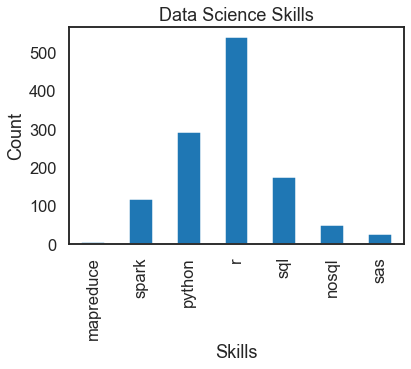

In [9]:
pseries = pd.Series(skill_set)
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

### Remarks



Code is based on the [2015 CS109 solution](https://github.com/cs109/2015/blob/master/Lectures/02-DataScrapingQuizzes.ipynb).
* some minor changes due to Python v2 vs v3 differences
* the number of jobresults per page is varying.
* quite a number of job links are duplicates. Might be due to advertisements.
* skill in language R is given the above code hard to find. As a consequence the final R count is too high. A solution migt be the approach by  [Jesse Steinweg-Woods](https://jessesw.com/Data-Science-Skills/)
* the searchCount is located on a different html location
* the searchCount on the first page is not always reliable. Example of 18 August 2020: searchCount 7, but 10 job postings on page. Or searchCount 20 and 18 on page(s). 